## Tugas Besar II IF3270 Pembelajaran Mesin - RNN

### Anggota Kelompok:
1. Suthasoma Mahardhika Munthe (13522098)
2. Marvin Scifo Y. Hutahaean (13522110)
3. Berto Richardo Togatorop (13522118)

In [86]:
import numpy as np
import pandas as pd
from customnn import RNN, Embedded, FullyConnected
from keras import layers, models

url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/train.csv"
url_valid = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/valid.csv"
url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/test.csv"

df_train = pd.read_csv(url_train)
df_valid = pd.read_csv(url_valid)
df_test = pd.read_csv(url_test)

In [78]:
max_tokens = 10000
output_sequence_length = 100

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorizer.adapt(df_train['text'])
vectorizer_data = vectorizer(df_train['text'])
vectorizer_test = vectorizer(df_test['text'])
vocabs = len(vectorizer.get_vocabulary())

y_train = df_train['label'].to_numpy()
y_test = df_test['label'].to_numpy()

In [79]:
embedder = Embedded(vocabs, 100, embeddings_initializer='xavier')
embedded_vector = embedder.forward(vectorizer_data)

print(embedded_vector.shape)

(500, 100, 100)


In [80]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_int = le.fit_transform(df_train['label'])
y_test_int = le.transform(df_test['label'])

In [81]:
models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.SimpleRNN(units=64),
    layers.Dense(units=vocabs, activation='softmax')
])

models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.0789 - loss: 7.9121 - val_accuracy: 0.2000 - val_loss: 7.6038
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2508 - loss: 7.4198 - val_accuracy: 0.2000 - val_loss: 6.7823
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2438 - loss: 6.5222 - val_accuracy: 0.2000 - val_loss: 5.6965
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2443 - loss: 5.4088 - val_accuracy: 0.2000 - val_loss: 4.5294
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2549 - loss: 4.2517 - val_accuracy: 0.2000 - val_loss: 3.4517
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2422 - loss: 3.2138 - val_accuracy: 0.2000 - val_loss: 2.5513
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3405 - loss: 2.3721 - val_accuracy: 0.3600 - val_loss: 1.9074
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3805 - loss: 1.7943 - val_accuracy: 0.3600 - val_loss: 1.5313


In [82]:
embedding_weights = models.layers[0].get_weights()[0]
rnn_weights = models.layers[1].get_weights()
kernel, recurrent_kernel, bias_rnn = rnn_weights
dense_weights = models.layers[2].get_weights()
kernel_dense, bias_dense = dense_weights

In [83]:
from sklearn.metrics import f1_score

class RNNFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.rnn1 = RNN(unit=64, input_size=100, timestep=100, return_sequence=False)
        self.fc1 = FullyConnected(input_size=64, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.rnn1.forward(self.embedding.forward(x)))
    
rnn_from_scratch = RNNFromScratch(vocabs=vocabs)

rnn_from_scratch.embedding.weight = embedding_weights.copy()
rnn_from_scratch.rnn1.input_weights = kernel.copy()
rnn_from_scratch.rnn1.hidden_weights = recurrent_kernel.copy()
rnn_from_scratch.rnn1.bias = bias_rnn.copy()
rnn_from_scratch.fc1.weights = kernel_dense.copy()
rnn_from_scratch.fc1.biases = bias_dense.copy()

sample_input = vectorizer_data.numpy()

keras_output = models(sample_input, training=False).numpy()

outputs = []
for i in range(sample_input.shape[0]):
    x = sample_input[i]
    output = rnn_from_scratch.forward(x)
    outputs.append(output)

outputs = np.stack(outputs)

keras_labels = np.argmax(keras_output, axis=1)
scratch_labels = np.argmax(outputs, axis=1)

f1 = f1_score(keras_labels, scratch_labels, average='macro')

print("Difference:", np.abs(keras_output - outputs).mean())
print("F1:", f1)


Difference: 8.214162805890805e-11
F1: 1.0


In [87]:
bi_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.Bidirectional(layers.SimpleRNN(units=64)),
    layers.Dense(units=vocabs, activation='softmax')
])
bi_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
bi_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = bi_models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.0535 - loss: 7.7939 - val_accuracy: 0.2000 - val_loss: 7.0014
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2598 - loss: 6.6349 - val_accuracy: 0.2000 - val_loss: 5.3080
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2577 - loss: 4.8365 - val_accuracy: 0.2000 - val_loss: 3.2966
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2632 - loss: 2.8634 - val_accuracy: 0.2000 - val_loss: 1.7709
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2424 - loss: 1.5931 - val_accuracy: 0.3600 - val_loss: 1.2485
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3752 - loss: 1.2065 - val_accuracy: 0.3600 - val_loss: 1.1158
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3960 - loss: 1.1210 - val_accuracy: 0.3600 - val_loss: 1.0838
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3805 - loss: 1.0910 - val_accuracy: 0.4400 - val_loss: 1.0745


In [88]:
bi_embedding_weights = bi_models.layers[0].get_weights()[0]
bi_rnn_weights = bi_models.layers[1].get_weights()
bi_kernel, bi_recurrent_kernel, bi_bias_rnn, bi_kernel_reverse, bi_recurrent_kernel_reverse, bi_bias_rnn_reverse = bi_rnn_weights
bi_dense_weights = bi_models.layers[2].get_weights()
bi_kernel_dense, bi_bias_dense = bi_dense_weights

In [95]:
class BiRNNFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.rnn1 = RNN(unit=64, input_size=100, timestep=100, return_sequence=False, bidirectional=True)
        self.fc1 = FullyConnected(input_size=64, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.rnn1.forward(self.embedding.forward(x)))
    
bi_rnn_from_scratch = BiRNNFromScratch(vocabs=vocabs)

bi_rnn_from_scratch.embedding.weight = bi_embedding_weights.copy()
bi_rnn_from_scratch.rnn1.input_weights = bi_kernel.copy()
bi_rnn_from_scratch.rnn1.hidden_weights = bi_recurrent_kernel.copy()
bi_rnn_from_scratch.rnn1.bias = bi_bias_rnn.copy()
bi_rnn_from_scratch.rnn1.input_weights_reverse = bi_kernel_reverse.copy()
bi_rnn_from_scratch.rnn1.hidden_weights_reverse = bi_recurrent_kernel_reverse.copy()
bi_rnn_from_scratch.rnn1.bias_reverse = bi_bias_rnn_reverse.copy()
bi_rnn_from_scratch.fc1.weights = bi_kernel_dense.copy()
bi_rnn_from_scratch.fc1.biases = bi_bias_dense.copy()

bi_sample_input = vectorizer_data.numpy()

bi_keras_output = bi_models(bi_sample_input, training=False).numpy()

bi_outputs = []
for i in range(bi_sample_input.shape[0]):
    x = bi_sample_input[i]
    bi_output = bi_rnn_from_scratch.forward(x)
    bi_outputs.append(bi_output)

bi_outputs = np.stack(bi_outputs)

bi_keras_labels = np.argmax(bi_keras_output, axis=1)
bi_scratch_labels = np.argmax(bi_outputs, axis=1)

bi_f1 = f1_score(bi_keras_labels, bi_scratch_labels, average='macro')

print("Difference:", np.abs(bi_keras_output - bi_outputs).mean())
print("F1:",bi_f1)


Difference: 2.3632283165060956e-10
F1: 1.0


In [92]:
# RNN Models Hyperparameter Analysis
rnn_models = [
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64, return_sequences=True),
        layers.SimpleRNN(units=128),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64, return_sequences=True),
        layers.SimpleRNN(units=128, return_sequences=True),
        layers.SimpleRNN(units=256),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=32),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=128),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.SimpleRNN(units=64)),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
]

In [ ]:
name_layers = [
    "1 Layer",
    "2 Layers",
    "3 Layers",
    "32 Cells",
    "64 Cells",
    "128 Cells",
    "Unidirectional",
    "Bidirectional"
]

1 Layer
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.3302 - loss: 1.0812 - val_accuracy: 0.3500 - val_loss: 1.2651
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3354 - loss: 1.0925 - val_accuracy: 0.4400 - val_loss: 1.2647
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3640 - loss: 1.0865 - val_accuracy: 0.3500 - val_loss: 1.2675
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3957 - loss: 1.0790 - val_accuracy: 0.3500 - val_loss: 1.2720
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3754 - loss: 1.0823 - val_accuracy: 0.3500 - val_loss: 1.2727
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3933 - loss: 1.0840 - val_accuracy: 0.3500 - val_loss: 1.2750
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4073 - loss: 1.0788 - val_accuracy: 0.3500 - val_loss: 1.2743
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3986 - loss: 1.0848 - val_accuracy: 0.4400 - val_loss:

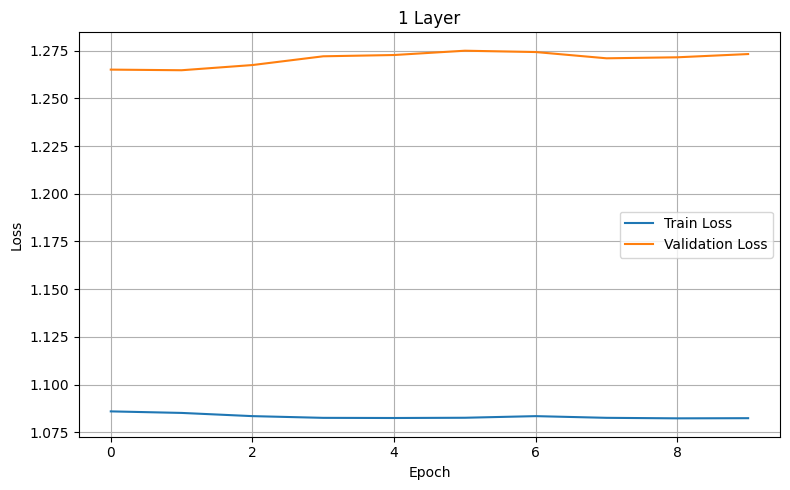


2 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.3126 - loss: 1.0915 - val_accuracy: 0.4400 - val_loss: 1.0589
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3881 - loss: 1.0878 - val_accuracy: 0.4400 - val_loss: 1.0577
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3870 - loss: 1.0868 - val_accuracy: 0.3600 - val_loss: 1.0897
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3880 - loss: 1.0887 - val_accuracy: 0.3600 - val_loss: 1.0793
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3875 - loss: 1.0774 - val_accuracy: 0.4400 - val_loss: 1.0635
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3723 - loss: 1.0819 - val_accuracy: 0.3600 - val_loss: 1.0688
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3808 - loss: 1.0757 - val_accuracy: 0.3600 - val_loss: 1.0741
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3833 - loss: 1.0857 - val_accuracy: 0.3600 - val_lo

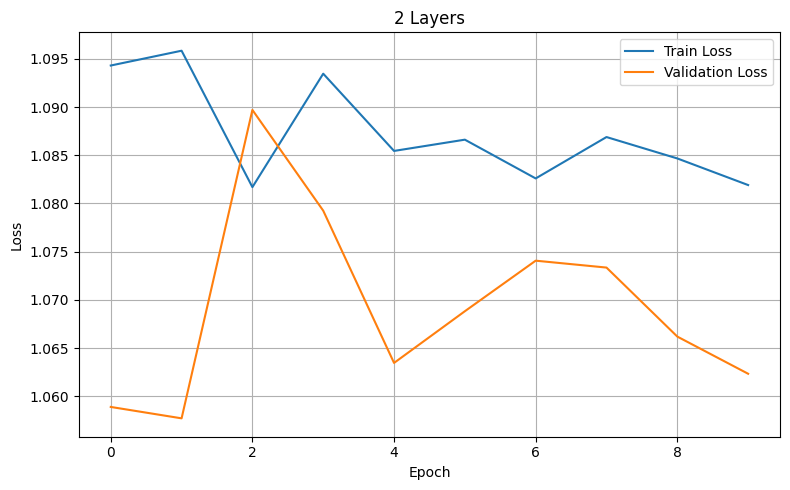


3 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.3533 - loss: 1.0986 - val_accuracy: 0.3600 - val_loss: 1.0905
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.3405 - loss: 1.1105 - val_accuracy: 0.4400 - val_loss: 1.0592
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.3718 - loss: 1.0806 - val_accuracy: 0.3600 - val_loss: 1.0761
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.3311 - loss: 1.0900 - val_accuracy: 0.4400 - val_loss: 1.0622
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.3578 - loss: 1.0956 - val_accuracy: 0.3600 - val_loss: 1.0852
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.3670 - loss: 1.0938 - val_accuracy: 0.4400 - val_loss: 1.0601
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.4035 - loss: 1.0798 - val_accuracy: 0.3600 - val_loss: 1.0707
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.3705 - loss: 1.1011 - val_accuracy: 0.3600 -

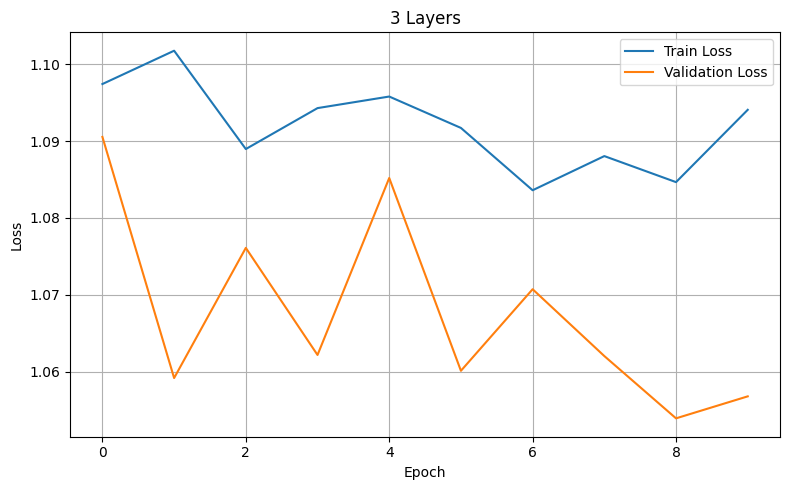


32 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.3735 - loss: 1.2493 - val_accuracy: 0.3600 - val_loss: 1.1894
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3727 - loss: 1.1969 - val_accuracy: 0.3600 - val_loss: 1.1507
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3808 - loss: 1.1717 - val_accuracy: 0.3600 - val_loss: 1.1272
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3852 - loss: 1.1487 - val_accuracy: 0.3600 - val_loss: 1.1101
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4001 - loss: 1.1251 - val_accuracy: 0.3600 - val_loss: 1.0976
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3667 - loss: 1.1198 - val_accuracy: 0.4400 - val_loss: 1.0917
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3704 - loss: 1.1263 - val_accuracy: 0.3600 - val_loss: 1.0919
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3901 - loss: 1.1108 - val_accuracy: 0.3600 - val_los

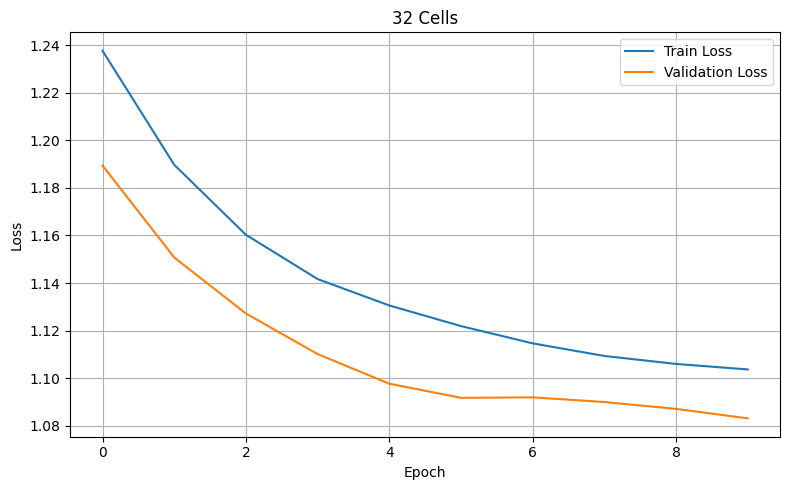


64 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.3450 - loss: 1.1005 - val_accuracy: 0.3600 - val_loss: 1.0728
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4057 - loss: 1.0806 - val_accuracy: 0.4400 - val_loss: 1.0632
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3667 - loss: 1.0821 - val_accuracy: 0.3600 - val_loss: 1.0702
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3944 - loss: 1.0785 - val_accuracy: 0.3600 - val_loss: 1.0729
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3976 - loss: 1.0832 - val_accuracy: 0.3600 - val_loss: 1.0701
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3847 - loss: 1.0815 - val_accuracy: 0.4400 - val_loss: 1.0623
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3772 - loss: 1.0855 - val_accuracy: 0.4400 - val_loss: 1.0627
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3688 - loss: 1.0835 - val_accuracy: 0.3600 - val_los

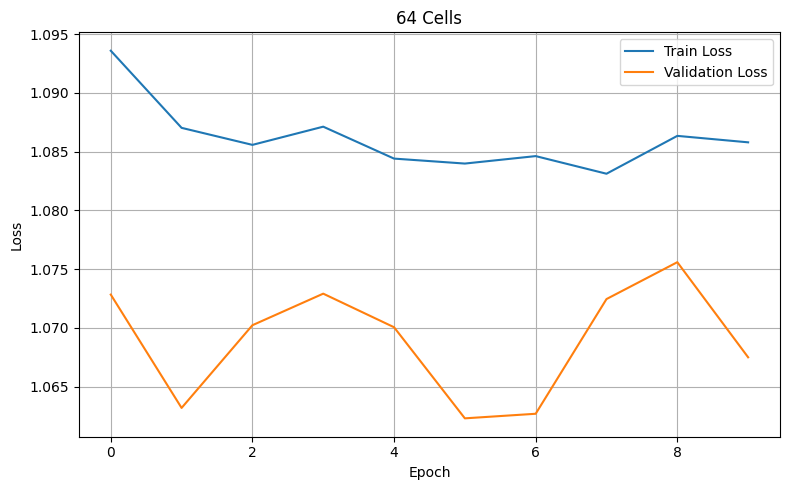


128 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3506 - loss: 1.0942 - val_accuracy: 0.3600 - val_loss: 1.0620
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3773 - loss: 1.0797 - val_accuracy: 0.4400 - val_loss: 1.0562
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3504 - loss: 1.0926 - val_accuracy: 0.4400 - val_loss: 1.0768
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3567 - loss: 1.0894 - val_accuracy: 0.3600 - val_loss: 1.0698
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3806 - loss: 1.0832 - val_accuracy: 0.3600 - val_loss: 1.0564
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3669 - loss: 1.0954 - val_accuracy: 0.4400 - val_loss: 1.0593
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3207 - loss: 1.0887 - val_accuracy: 0.3600 - val_loss: 1.0645
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3898 - loss: 1.0869 - val_accuracy: 0.3600 - val_l

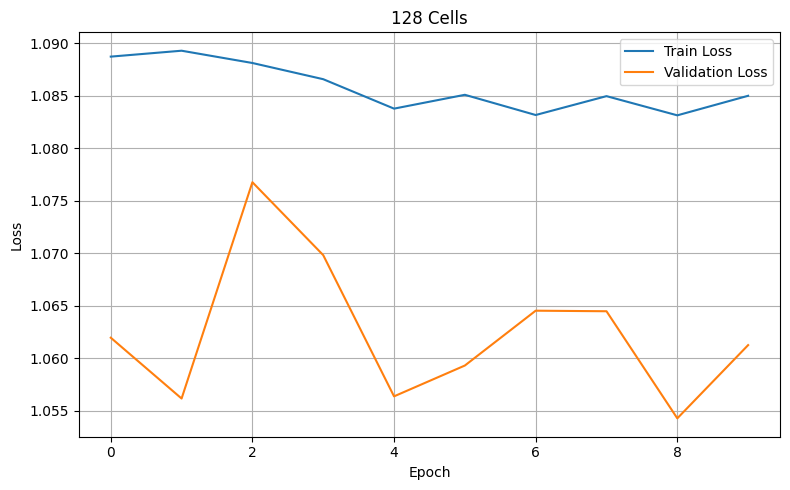


Unidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.3620 - loss: 1.0987 - val_accuracy: 0.4400 - val_loss: 1.0687
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3499 - loss: 1.0826 - val_accuracy: 0.3600 - val_loss: 1.0675
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3802 - loss: 1.0896 - val_accuracy: 0.4400 - val_loss: 1.0634
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3610 - loss: 1.0879 - val_accuracy: 0.4400 - val_loss: 1.0631
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3651 - loss: 1.0852 - val_accuracy: 0.3600 - val_loss: 1.0601
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3263 - loss: 1.0949 - val_accuracy: 0.3600 - val_loss: 1.0618
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3752 - loss: 1.0835 - val_accuracy: 0.3600 - val_loss: 1.0650
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3783 - loss: 1.0779 - val_accuracy: 0.3600 - v

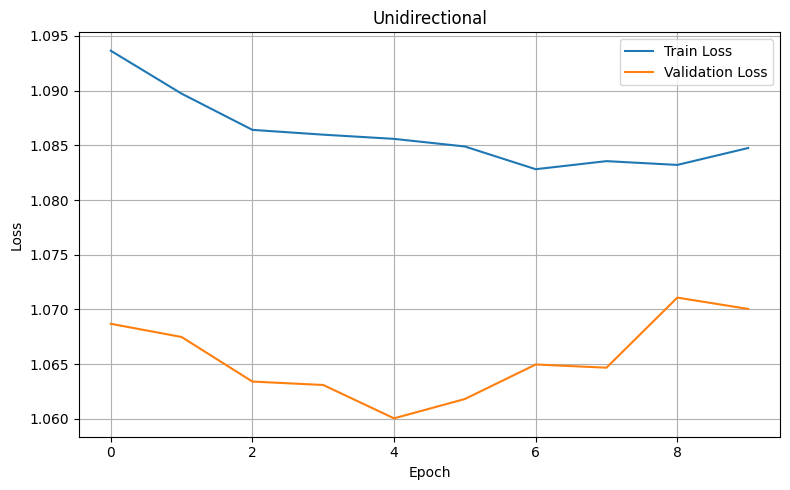


Bidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.8825 - loss: 0.7225 - val_accuracy: 0.5600 - val_loss: 0.9712
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9153 - loss: 0.6548 - val_accuracy: 0.5700 - val_loss: 0.9141
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8941 - loss: 0.5527 - val_accuracy: 0.5800 - val_loss: 0.9376
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9374 - loss: 0.4455 - val_accuracy: 0.6100 - val_loss: 0.9228
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9563 - loss: 0.3832 - val_accuracy: 0.6200 - val_loss: 0.8996
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9723 - loss: 0.3182 - val_accuracy: 0.6000 - val_loss: 0.9073
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9740 - loss: 0.2603 - val_accuracy: 0.5700 - val_loss: 0.9607
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9643 - loss: 0.2418 - val_accuracy: 0.6000 - v

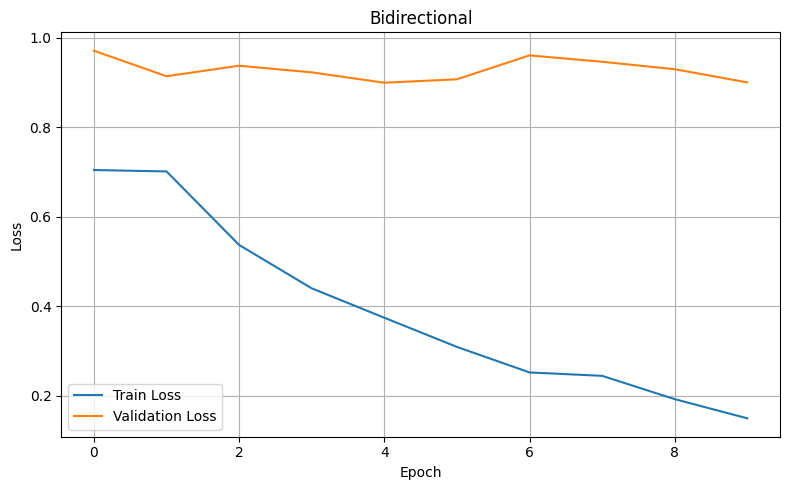

In [98]:
import matplotlib.pyplot as plt

n = 0

for model in rnn_models:
    print(name_layers[n])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    history = model.fit(
        vectorizer_data, y_train_int,
        epochs=10,
        batch_size=64,
        validation_split=0.2
    )
    test_loss, test_acc = model.evaluate(vectorizer_test, y_test_int)

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name_layers[n])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    n += 1
    print()

